In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import time

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

def show_image(image, label):
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    plt.title(f'Label: {label}')
    plt.show()

Libraries imported - ready to use PyTorch 2.4.0


In [2]:
# device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device="cpu"

print(f"Using {device} device")

# resume training options
resume_training = True

class Params:
    def __init__(self):
        self.batch_size = 48
        self.name = "resnet_152_sgd1"
        self.workers = 4
        self.lr = 0.002
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.lr_step_size = 30
        self.lr_gamma = 0.1

    def __repr__(self):
        return str(self.__dict__)

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
params = Params()
params, params.batch_size

Using cuda device


({'batch_size': 48, 'name': 'resnet_152_sgd1', 'workers': 4, 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_step_size': 30, 'lr_gamma': 0.1},
 48)

In [3]:
training_folder_name = '/home/xpz1/Downloads/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train'
val_folder_name = '/home/xpz1/Downloads/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val'

In [7]:
os.listdir(training_folder_name)

['n12144580',
 'n03743016',
 'n07831146',
 'n04081281',
 'n10565667',
 'n02823428',
 'n02128385',
 'n03125729',
 'n02098105',
 'n02483362',
 'n07718472',
 'n02093859',
 'n01667778',
 'n02966687',
 'n03124170',
 'n07875152',
 'n02134418',
 'n03450230',
 'n02066245',
 'n01665541',
 'n02444819',
 'n02231487',
 'n07693725',
 'n01847000',
 'n02086646',
 'n03492542',
 'n03535780',
 'n02981792',
 'n13052670',
 'n02085620',
 'n02111129',
 'n04482393',
 'n07613480',
 'n02398521',
 'n01753488',
 'n02107683',
 'n03764736',
 'n01968897',
 'n04069434',
 'n04579145',
 'n04235860',
 'n03529860',
 'n03642806',
 'n02794156',
 'n02113624',
 'n02666196',
 'n02325366',
 'n04008634',
 'n03100240',
 'n03944341',
 'n02391049',
 'n07749582',
 'n02804610',
 'n02410509',
 'n04409515',
 'n01582220',
 'n04372370',
 'n01829413',
 'n03775071',
 'n02815834',
 'n02102318',
 'n02389026',
 'n02105641',
 'n03854065',
 'n02110806',
 'n03838899',
 'n02108551',
 'n03814906',
 'n03657121',
 'n02219486',
 'n03372029',
 'n028

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0992203..2.6341858].


torch.Size([48, 3, 224, 224])


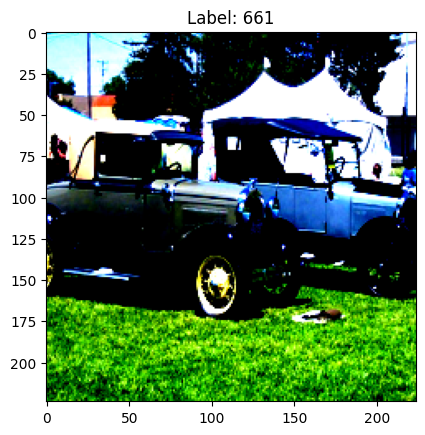

In [4]:
train_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
        transforms.RandomHorizontalFlip(0.5),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.ImageFolder(
    root=training_folder_name,
    transform=train_transformation
)
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=params.batch_size,
    sampler=train_sampler,
    num_workers = params.workers,
    pin_memory=True,
)
for X, y in train_loader:
    break
print(X.shape)
show_image(X[0], y[0])

In [94]:
params.batch_size

48

In [6]:
train_dataset[1337]

(tensor([[[-0.2684, -0.2667, -0.2542,  ..., -0.2213, -0.2025, -0.1999],
          [-0.2684, -0.2667, -0.2542,  ..., -0.2213, -0.2025, -0.1999],
          [-0.2684, -0.2667, -0.2542,  ..., -0.2213, -0.2025, -0.1999],
          ...,
          [-0.1299, -0.1233, -0.0743,  ...,  0.6540,  0.6191,  0.6144],
          [-0.1143, -0.1093, -0.0716,  ...,  0.4724,  0.5289,  0.5364],
          [-0.1143, -0.1093, -0.0716,  ...,  0.4724,  0.5289,  0.5364]],
 
         [[-0.0118, -0.0092,  0.0100,  ...,  0.0364,  0.0556,  0.0582],
          [-0.0118, -0.0092,  0.0100,  ...,  0.0364,  0.0556,  0.0582],
          [-0.0118, -0.0092,  0.0100,  ...,  0.0364,  0.0556,  0.0582],
          ...,
          [-0.0065, -0.0086, -0.0245,  ..., -1.0201, -0.9831, -0.9781],
          [-0.0118, -0.0153, -0.0409,  ..., -1.2558, -1.1469, -1.1323],
          [-0.0118, -0.0153, -0.0409,  ..., -1.2558, -1.1469, -1.1323]],
 
         [[ 0.7402,  0.7428,  0.7619,  ...,  0.7185,  0.7377,  0.7402],
          [ 0.7402,  0.7428,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6654462..2.5299704].


torch.Size([64, 3, 224, 224])


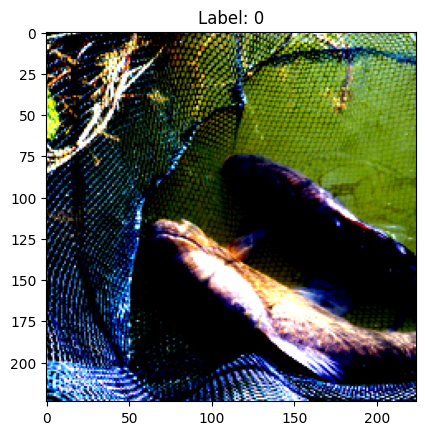

In [5]:
val_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=256, antialias=True),
        transforms.CenterCrop(224),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225])
    ])
val_dataset = torchvision.datasets.ImageFolder(
    root=val_folder_name,
    transform=val_transformation
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=params.workers,
    shuffle=False,
    pin_memory=True
)
for X, y in val_loader:
    break
print(X.shape)
show_image(X[0], y[0])

In [6]:
from math import sqrt
def train(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)
    model.train()
    start0 = time.time()
    start = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        batch_size = len(X)
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}], {(current/size * 100):>4f}%")
            step = epoch * size + current
            writer.add_scalar('training loss',
                            loss,
                            step)
            new_start = time.time()
            delta = new_start - start
            start = new_start
            if batch != 0:
                print("Done in ", delta, " seconds")
                remaining_steps = size - current
                speed = 100 * batch_size / delta
                remaining_time = remaining_steps / speed
                print("Remaining time (seconds): ", remaining_time)
        optimizer.zero_grad()
    print("Entire epoch done in ", time.time() - start0, " seconds")

In [8]:
def test(dataloader, model, loss_fn, epoch, writer, train_dataloader, calc_acc5=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, correct_top5 = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if calc_acc5:
                _, pred_top5 = pred.topk(5, 1, largest=True, sorted=True)
                correct_top5 += pred_top5.eq(y.view(-1, 1).expand_as(pred_top5)).sum().item()
    test_loss /= num_batches
    step = epoch * len(train_dataloader.dataset)
    if writer != None:
        writer.add_scalar('test loss',
                            test_loss,
                            step)
    correct /= size
    correct_top5 /= size
    if writer != None:
        writer.add_scalar('test accuracy',
                            100*correct,
                            step)
        if calc_acc5:
            writer.add_scalar('test accuracy5',
                            100*correct_top5,
                            step)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if calc_acc5:
        print(f"Test Error: \n Accuracy-5: {(100*correct_top5):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
## testing a pretrained model to validate correctness of our dataset, transform and metrics code
pretrained_model = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device)
start = time.time()
loss_fn = nn.CrossEntropyLoss()
test(val_loader, pretrained_model, loss_fn, epoch=0, writer=None, train_dataloader=train_loader, calc_acc5=True)
print("Elapsed: ", time.time() - start)

NameError: name 'test' is not defined

In [9]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        groups=groups,
        bias=False,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [10]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        base_width: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [11]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Bottleneck],
        layers: List[int],
        num_classes: int = 1000,
        width_per_group: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(
        self,
        block: Type[Union[Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.base_width, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    base_width=self.base_width,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [37]:
import torch
import gc

# Clear PyTorch's GPU cache
torch.cuda.empty_cache()

# Delete variables
del pretrained_model  # Replace with your variable names
del model

# Trigger garbage collection
gc.collect()

print(torch.cuda.memory_allocated() / 1e6, "MB allocated")
print(torch.cuda.memory_reserved() / 1e6, "MB reserved")

12402.157568 MB allocated
13004.439552 MB reserved


In [38]:
device = "cuda"
model = ResNet(Bottleneck, [3, 8, 36, 3]).to(device)
preds = model(X.to(device))
preds.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 54.88 MiB is free. Including non-PyTorch memory, this process has 23.21 GiB memory in use. Of the allocated memory 21.50 GiB is allocated by PyTorch, and 623.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [27]:
len(train_loader)



26691

100%|██████████| 5000/5000 [34:08<00:00,  2.44it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-06


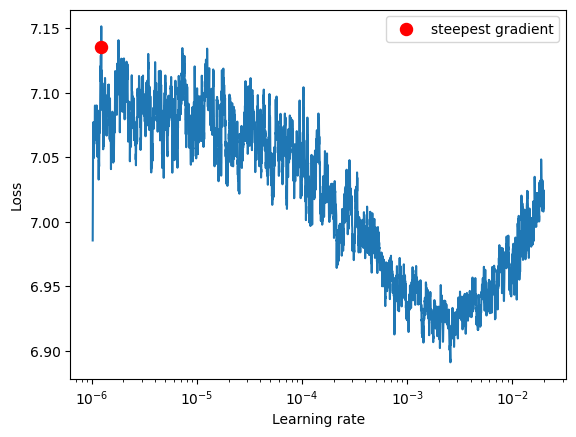

In [ ]:
#Tweaked version from fastai
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.02, num_iter=5000,smooth_f=0.1)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

100%|██████████| 5000/5000 [34:00<00:00,  2.45it/s]


Learning rate search finished. See the graph with {finder_name}.plot()


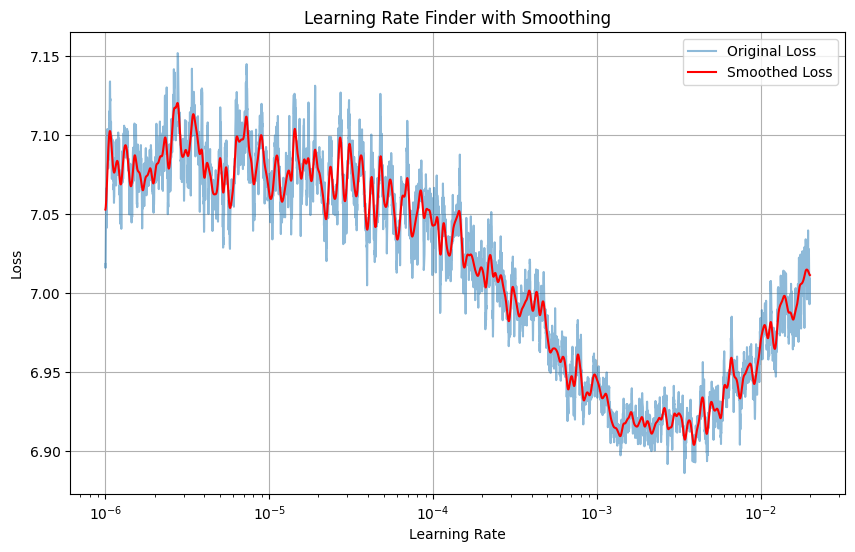

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Run the LR Finder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.02, num_iter=5000, smooth_f=0.1)

# Extract the history
lrs = lr_finder.history["lr"]
losses = lr_finder.history["loss"]

# Apply smoothing to the losses (e.g., Gaussian smoothing)
smoothed_losses = gaussian_filter1d(losses, sigma=10)  # Adjust sigma for smoothness

# Replot the smoothed curve
plt.figure(figsize=(10, 6))
plt.plot(lrs, losses, label="Original Loss", alpha=0.5)
plt.plot(lrs, smoothed_losses, label="Smoothed Loss", color="red")
plt.xscale("log")  # Use log scale for learning rate
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder with Smoothing")
plt.legend()
plt.grid(True)
plt.show()

# Reset the model and optimizer
lr_finder.reset()


100%|██████████| 5000/5000 [33:20<00:00,  2.50it/s]


Learning rate search finished. See the graph with {finder_name}.plot()


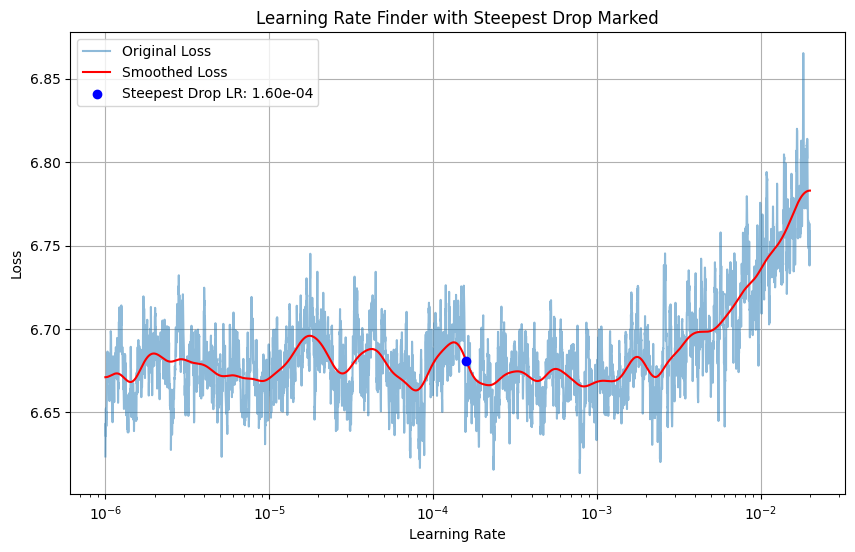

Learning rate with steepest drop in loss: 1.60e-04


In [34]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Run the LR Finder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.02, num_iter=5000, smooth_f=0.1)

# Extract the history
lrs = lr_finder.history["lr"]
losses = lr_finder.history["loss"]
# Apply smoothing to the losses (e.g., Gaussian smoothing)
smoothed_losses = gaussian_filter1d(losses, sigma=50)  # Adjust sigma for smoothness

# Compute the gradients (rate of change of loss w.r.t. learning rate)
gradients = np.gradient(smoothed_losses, np.log(lrs))  # Use log scale for learning rate

# Find the index of the steepest drop (minimum gradient)
min_grad_idx = np.argmin(gradients)
optimal_lr = lrs[min_grad_idx]  # Learning rate with steepest drop

# Plot the smoothed curve with the optimal learning rate
plt.figure(figsize=(10, 6))
plt.plot(lrs, losses, label="Original Loss", alpha=0.5)
plt.plot(lrs, smoothed_losses, label="Smoothed Loss", color="red")
plt.scatter(optimal_lr, smoothed_losses[min_grad_idx], color="blue", label=f"Steepest Drop LR: {optimal_lr:.2e}", zorder=5)
plt.xscale("log")  # Use log scale for learning rate
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder with Steepest Drop Marked")
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal learning rate
print(f"Learning rate with steepest drop in loss: {optimal_lr:.2e}")

# Reset the model and optimizer
lr_finder.reset()

In [26]:
#Leslie Smith's approach
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

  1%|          | 1/100 [04:02<6:40:56, 242.99s/it]


KeyboardInterrupt: 

In [36]:
params.weight_decay

0.0001

In [35]:
params.lr = 0.0001
params.lr

0.0001

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=params.lr, momentum=params.momentum, weight_decay=params.weight_decay)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params.lr_step_size, gamma=params.lr_gamma)
lr_scheduler  = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002, total_steps=None, epochs=100, 
                   steps_per_epoch=26691, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, 
                   base_momentum=0.85, max_momentum=0.95, div_factor=10.0, final_div_factor=1000.0, 
                   three_phase=False, last_epoch=-1, verbose='deprecated')


In [29]:
start_epoch = 0
checkpoint_path = os.path.join("checkpoints", params.name, f"checkpoint.pth")
if resume_training and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model"])
    start_epoch = checkpoint["epoch"] + 1
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
    assert params == checkpoint["params"]

In [30]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
Path(os.path.join("checkpoints", params.name)).mkdir(parents=True, exist_ok=True)
writer = SummaryWriter('runs/' + params.name)
test(val_loader, model, loss_fn, epoch=0, writer=writer, train_dataloader=train_loader, calc_acc5=True)
for epoch in range(start_epoch, 100):
    print (f"Running Epoch:{epoch} ")
    train(train_loader, model, loss_fn, optimizer, epoch=epoch, writer=writer)
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "lr_scheduler": lr_scheduler.state_dict(),
        "epoch": epoch,
        "params": params
    }
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"model_{epoch}.pth"))
    torch.save(checkpoint, os.path.join("checkpoints", params.name, f"checkpoint.pth"))
    lr_scheduler.step()
    test(val_loader, model, loss_fn, epoch + 1, writer, train_dataloader=train_loader, calc_acc5=True)

Test Error: 
 Accuracy: 0.1%, Avg loss: 26.219383 

Test Error: 
 Accuracy-5: 0.5%, Avg loss: 26.219383 

Running Epoch:0 
loss: 7.176449  [   48/1281167], 0.003747%
loss: 6.938278  [ 4848/1281167], 0.378405%
Done in  40.55721974372864  seconds
Remaining time (seconds):  10784.156280436664
loss: 7.114540  [ 9648/1281167], 0.753063%
Done in  41.16823673248291  seconds
Remaining time (seconds):  10905.457333718738
loss: 6.921842  [14448/1281167], 1.127722%
Done in  41.79714870452881  seconds
Remaining time (seconds):  11030.25883538584
loss: 6.904596  [19248/1281167], 1.502380%
Done in  42.1449248790741  seconds
Remaining time (seconds):  11079.891970515897
loss: 6.860582  [24048/1281167], 1.877039%
Done in  41.80154776573181  seconds
Remaining time (seconds):  10947.816651189376
loss: 6.930620  [28848/1281167], 2.251697%
Done in  42.36651921272278  seconds
Remaining time (seconds):  11053.416036241204
loss: 6.892923  [33648/1281167], 2.626356%
Done in  42.34992814064026  seconds
Remaini

KeyboardInterrupt: 